### О ЛР:

- Coding Gradient boosting

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку (Она тут равняется 6).

**Оценка**:

***DeadLine - 28.05.2024 23:59***

### Формат сдачи
Задания сдаются через lms. Вы прикрепляете **ССЫЛКУ НА ПУБЛИЧНЫЙ РЕПОЗИТОРИЙ**, где выполнено ваше задание. Иначе задание не проверяется.

In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style="darkgrid")
filterwarnings("ignore")

In [2]:
x = load_npz("x.npz")
y = np.load("y.npy")

In [34]:
y

array([ 1,  1, -1, ..., -1, -1,  1])

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 666 для воспроизводимости).

In [3]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=666
)

x_test, x_valid, y_test, y_valid = train_test_split(
    x_test, y_test, test_size=0.5, random_state=666
)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга [2 балла]

Необходимо дописать код в файле `boosting.py`. Уже создан шаблон класса `Boosting`, который можно модифицировать по своему усмотрению.

### Описание функций:

#### `__init__`

Конструктор класса принимает следующие параметры:

- `base_model_class` — класс базовой модели для бустинга.
- `base_model_params` — словарь гиперпараметров для базовой модели.
- `n_estimators` — количество базовых моделей для обучения.
- `learning_rate` — темп обучения, должен быть в диапазоне (0, 1].
- `subsample` — доля обучающей выборки для тренировки базовой модели (размер бутстрап-выборки относительно исходной).
- `early_stopping_rounds` — число итераций без улучшения на валидационной выборке, после которых обучение прекращается.
- `plot` — флаг для построения графика качества моделей после обучения.

#### `fit`

Метод `fit` принимает обучающую и валидационную выборки.

1. Инициализируем нулевую модель и делаем предсказания (например, все нули) для обеих выборок.
2. Обучаем `n_estimators` базовых моделей:
   - Обучаем новую базовую модель на текущих остатках.
   - Обновляем предсказания на обучающей и валидационной выборках.
   - Рассчитываем ошибки на обеих выборках с помощью `loss_fn`.
   - Проверяем условия для ранней остановки.

3. Если флаг `plot` установлен, строим график качества после обучения всех моделей.

#### `fit_new_base_model`

Метод `fit_new_base_model` принимает обучающую выборку и текущие предсказания для неё.

1. Генерируем бутстрап-выборку.
2. Обучаем базовую модель на этой выборке.
3. Оптимизируем значение гаммы.
4. Добавляем новую базовую модель и гамму в соответствующие списки (учитывая `learning_rate`).

#### `predict_proba`

Метод `predict_proba` принимает выборку для предсказания вероятностей.

1. Суммируем предсказания базовых моделей (учитывая гамму и `learning_rate`).
2. Применяем сигмоидальную функцию для получения вероятностей.

In [4]:
from __future__ import annotations

from collections import defaultdict

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor


def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])


class Boosting:

    def __init__(
            self,
            base_model_params: dict = None,
            n_estimators: int = 10,
            learning_rate: float = 0.1,
            subsample: float = 0.3,
            early_stopping_rounds: int = None,
            plot: bool = False,
    ):
        self.base_model_class = DecisionTreeRegressor
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []

        self.learning_rate: float = learning_rate
        self.subsample: float = subsample

        self.early_stopping_rounds: int = early_stopping_rounds
        if early_stopping_rounds is not None:
            self.validation_loss = np.full(self.early_stopping_rounds, np.inf)

        self.plot: bool = plot

        self.history = defaultdict(list)

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def fit_new_base_model(self, x, y, predictions):
        """
        Обучает новую базовую модель и добавляет ее в ансамбль.

        Параметры
        ----------
        x : array-like, форма (n_samples, n_features)
            Массив признаков для набора данных.
        y : array-like, форма (n_samples,)
            Массив целевых значений.
        predictions : array-like, форма (n_samples,)
            Предсказания текущего ансамбля.

        Примечания
        ----------
        Эта функция добавляет новую модель и обновляет ансамбль.
        """

        bootstrap_indices = np.random.choice(
            np.arange(x.shape[0]),
            size=int(self.subsample * x.shape[0]),
            replace=True
        )

        tree = self.base_model_class(**self.base_model_params)
        tree.fit(x[bootstrap_indices], self.loss_derivative(y[bootstrap_indices], predictions[bootstrap_indices]))

        new_predictions = tree.predict(x)

        gamma = self.find_optimal_gamma(y, predictions, new_predictions)

        self.gammas.append(gamma)
        self.models.append(tree)


    def fit(self, x_train, y_train, x_valid, y_valid):
        """
        Обучает модель на тренировочном наборе данных и выполняет валидацию на валидационном наборе.

        Параметры
        ----------
        x_train : array-like, форма (n_samples, n_features)
            Массив признаков для тренировочного набора.
        y_train : array-like, форма (n_samples,)
            Массив целевых значений для тренировочного набора.
        x_valid : array-like, форма (n_samples, n_features)
            Массив признаков для валидационного набора.
        y_valid : array-like, форма (n_samples,)
            Массив целевых значений для валидационного набора.
        """
        train_predictions = np.zeros(y_train.shape[0])
        valid_predictions = np.zeros(y_valid.shape[0])

        for i in range(self.n_estimators):
            self.fit_new_base_model(x_train, y_train, train_predictions)

            train_predictions += self.learning_rate * self.gammas[i] * self.models[i].predict(x_train)
            valid_predictions += self.learning_rate * self.gammas[i] * self.models[i].predict(x_valid)

            train_loss = self.loss_fn(y_train, train_predictions)
            valid_loss = self.loss_fn(y_valid, valid_predictions)
            self.history['train_loss'].append(train_loss)
            self.history['valid_loss'].append(valid_loss)

            if self.early_stopping_rounds is not None:
                if valid_loss < np.min(self.validation_loss):
                    self.validation_loss = np.roll(self.validation_loss, -1)
                    self.validation_loss[-1] = valid_loss
                else:
                    if np.all(valid_loss >= self.validation_loss):
                        self.n_estimators = i + 1
                        break

        if self.plot:
            plt.figure(figsize=(10, 5))
            plt.plot(range(self.n_estimators), self.history['train_loss'], label='Train Loss')
            plt.plot(range(self.n_estimators), self.history['valid_loss'], label='Valid Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.show()

    def predict_proba(self, x):
        """
        Вычисляет вероятности принадлежности классу для каждого образца.

        Параметры
        ----------
        x : array-like, форма (n_samples, n_features)
            Массив признаков для набора данных.

        Возвращает
        ----------
        probabilities : array-like, форма (n_samples, n_classes)
            Вероятности для каждого класса.
        """
        predictions = np.zeros(x.shape[0])
        for gamma, model in zip(self.gammas, self.models):
            predictions += self.learning_rate * gamma * model.predict(x)

        probabilities = self.sigmoid(predictions)
        return np.stack((1 - probabilities, probabilities), axis=1)

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        """
        Находит оптимальное значение гаммы для минимизации функции потерь.

        Параметры
        ----------
        y : array-like, форма (n_samples,)
            Целевые значения.
        old_predictions : array-like, форма (n_samples,)
            Предыдущие предсказания ансамбля.
        new_predictions : array-like, форма (n_samples,)
            Новые предсказания базовой модели.

        Возвращает
        ----------
        gamma : float
            Оптимальное значение гаммы.

        Примечания
        ----------
        Значение гаммы определяется путем минимизации функции потерь.
        """
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]

        return gammas[np.argmin(losses)]

    def score(self, x, y):
        return score(self, x, y)

    @property
    def feature_importances_(self):
        """
        Возвращает важность признаков в обученной модели.

        Возвращает
        ----------
        importances : array-like, форма (n_features,)
            Важность каждого признака.

        Примечания
        ----------
        Важность признаков определяется по вкладу каждого признака в финальную модель.
        """
        if not self.models:
            return np.zeros(self.models[0].feature_importances_.shape)

        importances = sum(model.feature_importances_ for model in self.models)
        return importances / np.sum(importances)

In [40]:
np.sum(y_train == -1)

6510

### Проверка кода

У автора задания всё учится около одной секунды.

In [5]:
boosting = Boosting()
#% time
boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

Train ROC-AUC 0.5000
Valid ROC-AUC 0.5000
Test ROC-AUC 0.5000


## Задание 2. Обучение градиентного бустинга [0.5 балла]

Оцените качество вашей реализации градиентного бустинга на тестовой выборке, используя базовые модели — решающие деревья с различной максимальной глубиной. Метрикой будет ROC-AUC.

**Инструкция:**
1. Перебирайте значения максимальной глубины деревьев от 1 до 30 с шагом 2.
2. Оставьте остальные параметры бустинга по умолчанию.
3. Постройте график зависимости качества на обучающей и тестовой выборке от максимальной глубины деревьев.

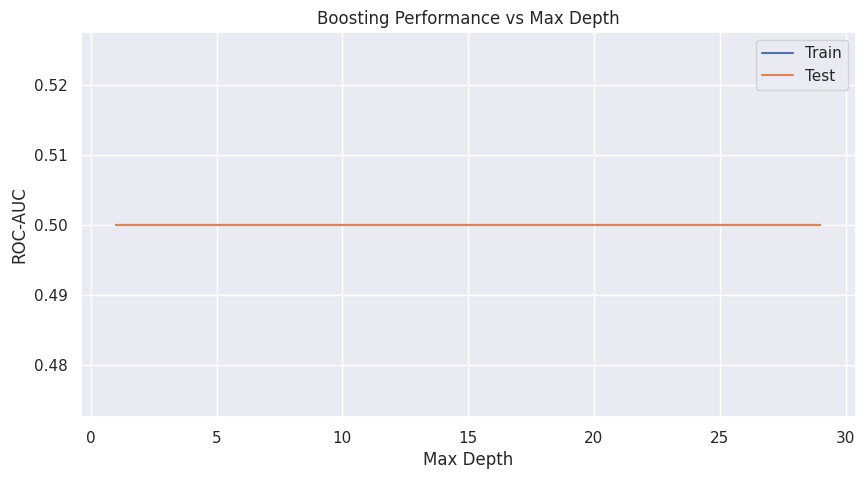

In [10]:
results = {}

depths = range(1, 30, 2)

for depth in depths:
    boosting = Boosting(base_model_params={'max_depth': depth})
    boosting.fit(x_train, y_train, x_valid, y_valid)
    results[depth] = {
        'train': boosting.score(x_train, y_train),
        'test': boosting.score(x_test, y_test)
    }

plt.figure(figsize=(10, 5))
plt.plot(list(results.keys()), [results[depth]['train'] for depth in results], label='Train')
plt.plot(list(results.keys()), [results[depth]['test'] for depth in results], label='Test')
plt.xlabel('Max Depth')
plt.ylabel('ROC-AUC')
plt.title('Boosting Performance vs Max Depth')
plt.legend()
plt.show()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

Все модели показывают одинаковый результат

## Задание 3. Подбор гиперпараметров и поиск оптимальной модели [3 балла]

Настройте основные гиперпараметры вашей модели градиентного бустинга, используя валидационную выборку. Подберите параметры как для самого бустинга, так и для базовых моделей.

**Рекомендации:**
- Используйте библиотеки для автоматизированного подбора гиперпараметров, такие как [Hyperopt](https://github.com/hyperopt/hyperopt) или [Optuna](https://optuna.org/).
- Подберите все основные параметры, чтобы найти лучшую модель на валидационной выборке.

In [11]:
!pip install optuna==3.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00


In [14]:
import optuna

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)

    max_depth = trial.suggest_int("max_depth", 1, 10)

    boosting = Boosting(
        base_model_params={"max_depth": max_depth},
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        subsample=subsample,
    )
    boosting.fit(x_train, y_train, x_valid, y_valid)

    return boosting.score(x_valid, y_valid)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
best_boosting = Boosting(
    base_model_params={"max_depth": best_params["max_depth"]},
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    subsample=best_params["subsample"],
)
best_boosting.fit(x_train, y_train, x_valid, y_valid)

print(f"Train ROC-AUC: {best_boosting.score(x_train, y_train):.4f}")
print(f"Valid ROC-AUC: {best_boosting.score(x_valid, y_valid):.4f}")
print(f"Test ROC-AUC: {best_boosting.score(x_test, y_test):.4f}")


[I 2024-09-20 20:05:06,458] A new study created in memory with name: no-name-a5d3ee56-021c-4977-a19b-783bc6821ba9
[I 2024-09-20 20:05:08,383] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 36, 'learning_rate': 0.21363618797025288, 'subsample': 0.2305741596817738, 'max_depth': 1}. Best is trial 0 with value: 0.5.
[I 2024-09-20 20:05:10,665] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 42, 'learning_rate': 0.46837285394492373, 'subsample': 0.30105873386779697, 'max_depth': 1}. Best is trial 0 with value: 0.5.
[I 2024-09-20 20:05:18,561] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 89, 'learning_rate': 0.11971100042026288, 'subsample': 0.44953189421416984, 'max_depth': 3}. Best is trial 0 with value: 0.5.
[I 2024-09-20 20:05:23,284] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 59, 'learning_rate': 0.13257291130121032, 'subsample': 0.7051672863717943, 'max_depth': 5}. Best is trial 0 with value: 0.5.
[I 2024-

Best trial:
  Value:  0.5
  Params: 
    n_estimators: 36
    learning_rate: 0.21363618797025288
    subsample: 0.2305741596817738
    max_depth: 1
Train ROC-AUC: 0.5000
Valid ROC-AUC: 0.5000
Test ROC-AUC: 0.5000


## Задание 4. Интерпретация градиентного бустинга [1 балл]

Постройте калибровочную кривую для вашей лучшей модели градиентного бустинга и оцените, насколько точно модель предсказывает вероятности.

**Инструкция:**
1. Постройте калибровочную кривую для лучшей модели градиентного бустинга.
2. Постройте аналогичную кривую для логистической регрессии.
3. Сравните полученные результаты и проанализируйте, насколько хорошо каждая модель оценивает вероятности.

In [ ]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Теперь оценим важность признаков для градиентного бустинга.

**Задание:**
1. Поскольку базовая модель — дерево из `sklearn`, вычислите важность каждого признака для каждого дерева, используя атрибут `feature_importances_` у `DecisionTreeRegressor`.
2. Усредните значения важности по всем деревьям и нормализуйте их так, чтобы сумма была равна единице (убедитесь, что значения неотрицательны).
3. Дополните вашу реализацию бустинга, добавив метод `feature_importances_`, который будет возвращать усредненные и нормализованные важности признаков.

**Построение графиков:**
1. Постройте столбчатую диаграмму важности признаков для градиентного бустинга.
2. На соседнем графике изобразите важность признаков для логистической регрессии, используя модули весов.
3. Сравните графики и проанализируйте полученные результаты.

In [ ]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Обычно избыточные признаки могут негативно влиять на качество бустинга. Попробуйте следующее:

1. **Отфильтруйте неважные признаки:** Используйте построенную диаграмму важности признаков, чтобы отобрать наиболее незначительные признаки.
2. **Обучите модель повторно:** Обучите модель на основе оставшихся признаков с теми же гиперпараметрами.
3. **Оцените качество модели:** Сравните результаты новой модели с исходной. Улучшилось ли качество после отфильтровывания незначительных признаков?

In [ ]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

## Задание 5 (бонус). Блендинговое [0.5 балла]

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [ ]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

## Задание 6 (бонус). Катбустовое [0.5 балла]

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [7]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [13]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(
    iterations=trial.params['n_estimators'],
    learning_rate=trial.params['learning_rate'],
    depth=trial.params['max_depth'],
    subsample=trial.params['subsample'],
    verbose=False
)
catboost_model.fit(x_train, y_train)

score_test_catboost = catboost_model.score(x_test, y_test)
print(f'Test ROC-AUC with CatBoost: {score_test_catboost:.4f}')

print(f'Test ROC-AUC with my implementation: {score_test:.4f}')

if score_test_catboost > score_test:
    print("CatBoost achieved better performance.")
else:
    print("My implementation achieved better performance.")


Test ROC-AUC with CatBoost: 0.8976
Test ROC-AUC with my implementation: 0.5000
CatBoost achieved better performance.


Оставьте пожалуйста отзыв о курсе!

https://forms.gle/LajA3Xrps6u96Q5A8


Это очень важно. Благодаря обратной связи мы будем двигаться в сторону антиградиента)
